In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

from lume_model.calibrations.torch_model.decoupled_linear import DecoupledLinear
from lume_model.calibrations.torch_model.utils import extract_transformers
from lume_model.training.torch_model.train import create_dataset, train

# fix random seed
torch.manual_seed(0)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Create Miscalibrated Model and Example Data

In [3]:
# create base model
base_model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
).double()
base_model.requires_grad_(False)
base_model.to(device)

# create example data
x = torch.rand((100, 5), dtype=torch.double, device=device)
pred = base_model(x)

In [4]:
# create miscalibrated model
x_size, y_size = x.shape[1], pred.shape[1]
miscal_scale = 0.3
y_mask = [True, False]  # selects which parts of the output parameters are used
miscal_model = DecoupledLinear(
    model=base_model,
    x_size=x_size,
    y_size=y_size,
    x_offset_initial=miscal_scale * torch.rand(x_size),
    x_scale_initial=torch.ones(x_size) + miscal_scale * torch.rand(x_size),
    y_offset_initial=miscal_scale * torch.rand(y_size),
    y_scale_initial=torch.ones(y_size) + miscal_scale * torch.rand(y_size),
    y_mask=y_mask,
)
miscal_model.requires_grad_(False)
miscal_model.to(device)

DecoupledLinear(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
  (x_offset_prior): NormalPrior()
  (x_scale_prior): GammaPrior()
  (raw_x_scale_constraint): Positive()
  (y_offset_prior): NormalPrior()
  (y_scale_prior): GammaPrior()
  (raw_y_scale_constraint): Positive()
)

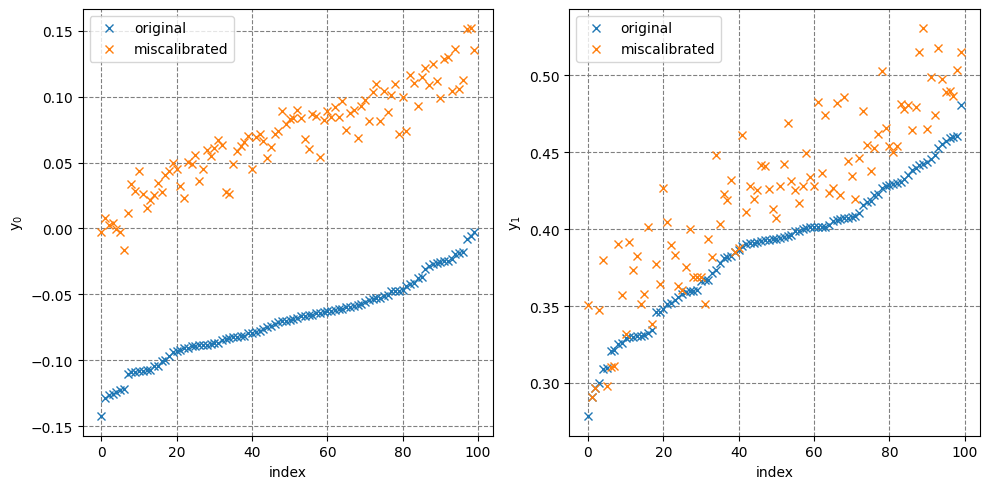

In [5]:
# miscalibrated predictions
miscal_pred = miscal_model(x)
fig, ax = plt.subplots(nrows=1, ncols=y_size, figsize=(5 * y_size, 5))
for i in range(y_size):
    idx_sort = torch.argsort(pred[:, i])
    ax[i].plot(pred[idx_sort, i].cpu(), "C0x", label="original")
    ax[i].plot(miscal_pred[idx_sort, i].cpu(), "C1x", label="miscalibrated")
    ax[i].grid(color="gray", linestyle="dashed")
    ax[i].set_xlabel("index")
    ax[i].set_ylabel(f"y$_{i}$")
    ax[i].legend(loc="upper left")
fig.tight_layout()

## Create and Train Calibrated Model

In [6]:
# create calibrated model
cal_model = DecoupledLinear(
    model=miscal_model,
    x_size=x_size,
    y_size=y_size,
    y_mask=y_mask,
)
cal_model.to(device)

DecoupledLinear(
  (model): DecoupledLinear(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (x_offset_prior): NormalPrior()
    (x_scale_prior): GammaPrior()
    (raw_x_scale_constraint): Positive()
    (y_offset_prior): NormalPrior()
    (y_scale_prior): GammaPrior()
    (raw_y_scale_constraint): Positive()
  )
  (x_offset_prior): NormalPrior()
  (x_scale_prior): GammaPrior()
  (raw_x_scale_constraint): Positive()
  (y_offset_prior): NormalPrior()
  (y_scale_prior): GammaPrior()
  (raw_y_scale_constraint): Positive()
)

In [7]:
# define trainable parameters
trainable_params = cal_model.raw_calibration_parameters
trainable_params

[Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([0., 0.], requires_grad=True),
 Parameter containing:
 tensor([0., 0.], requires_grad=True)]

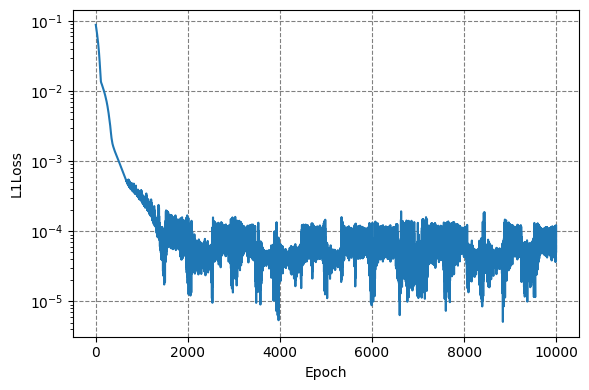

In [8]:
# Default values used here for most params
trainloader = create_dataset(x, pred)
cal_model, losses = train(
    model=cal_model,
    trainloader=trainloader,
    params=trainable_params,
    epochs=int(1e4),
    verbose=False,
    plot=True,
)

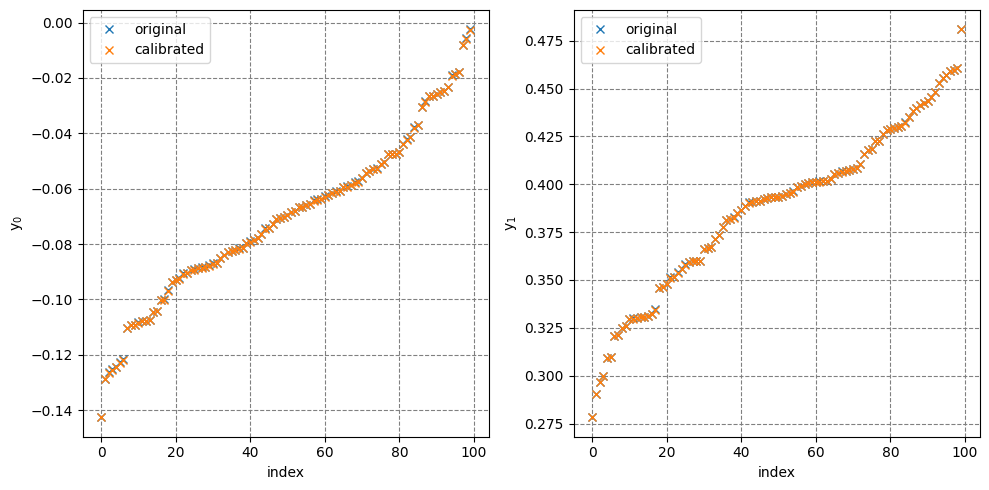

In [9]:
# calibrated predictions
with torch.no_grad():
    cal_pred = cal_model(x)
fig, ax = plt.subplots(nrows=1, ncols=y_size, figsize=(5 * y_size, 5))
for i in range(y_size):
    idx_sort = torch.argsort(pred[:, i])
    ax[i].plot(pred[idx_sort, i].cpu(), "C0x", label="original")
    ax[i].plot(cal_pred[idx_sort, i].cpu(), "C1x", label="calibrated")
    ax[i].grid(color="gray", linestyle="dashed")
    ax[i].set_xlabel("index")
    ax[i].set_ylabel(f"y$_{i}$")
    ax[i].legend(loc="upper left")
fig.tight_layout()

In [10]:
# calibration parameters
df_x = pd.DataFrame(
    columns=[["x_offset"] * 2 + ["x_scale"] * 2, ["target", "learned"] * 2]
)
df_y = pd.DataFrame(
    columns=[["y_offset"] * 2 + ["y_scale"] * 2, ["target", "learned"] * 2]
)
for df in [df_x, df_y]:
    for col in df.columns:
        model = miscal_model
        if col[-1] == "learned":
            model = cal_model
        values = getattr(model, col[0])
        if col[-1] == "learned":
            if "offset" in col[0]:
                values = -values
            elif "scale" in col[0]:
                values = 1.0 / values
        df.loc[:, col] = values.detach().cpu().tolist()
pd.set_option("display.float_format", "{:.4f}".format)

In [11]:
df_x

x_offset         x_scale        
    target learned  target learned
0   0.2047  0.2321  1.1372  1.1368
1   0.1332  0.1517  1.1408  1.1406
2   0.2101  0.2220  1.0559  1.0555
3   0.2559  0.2809  1.0957  1.0957
4   0.2152  0.2672  1.2475  1.2469

In [12]:
df_y

y_offset         y_scale        
    target learned  target learned
0   0.0899  0.0981  1.0905  1.0898
1   0.0000 -0.0000  1.0000  1.0000

## Use Transformers to Build Calibrated Model

In [13]:
# extract transformers from calibrated model
input_transformer, output_transformer = extract_transformers(cal_model)


# define transformed model
class TransformedModel(nn.Module):
    def __init__(self, model, input_transformer, output_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer

    def forward(self, x):
        x = self.input_transformer(x)
        x = self.model(x)
        x = self.output_transformer.untransform(x)
        return x


# create transformed model
transformed_model = TransformedModel(
    miscal_model, input_transformer, output_transformer
)

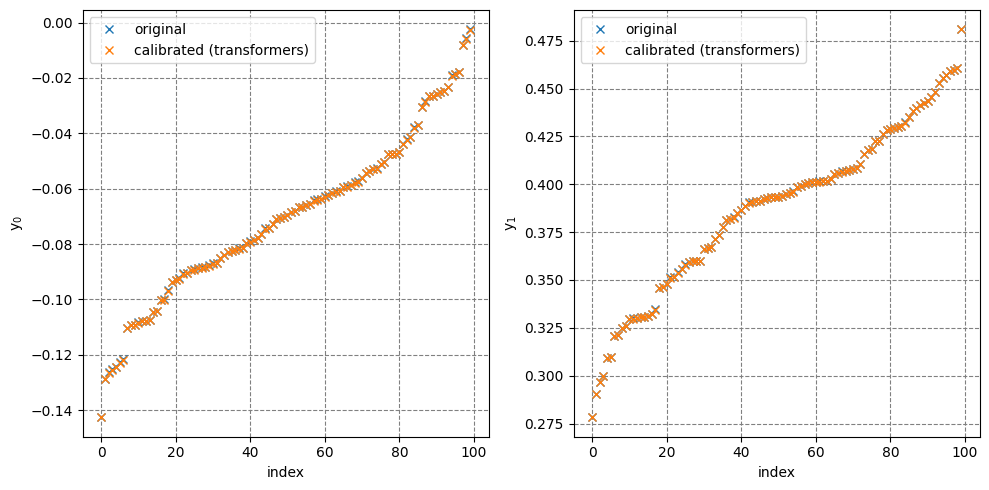

In [14]:
# predictions with transformed model
with torch.no_grad():
    transformed_pred = transformed_model(x)
fig, ax = plt.subplots(nrows=1, ncols=y_size, figsize=(5 * y_size, 5))
for i in range(y_size):
    idx_sort = torch.argsort(pred[:, i])
    ax[i].plot(pred[idx_sort, i].cpu(), "C0x", label="original")
    ax[i].plot(
        transformed_pred[idx_sort, i].cpu(), "C1x", label="calibrated (transformers)"
    )
    ax[i].grid(color="gray", linestyle="dashed")
    ax[i].set_xlabel("index")
    ax[i].set_ylabel(f"y$_{i}$")
    ax[i].legend(loc="upper left")
fig.tight_layout()